In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Load data

In [2]:
DATA_FOLDER = '../readonly/final_project_data/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


# Data Preprocessing
## Aggregate daily data into monthly data

In [3]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols).agg({'item_cnt_day': np.sum, 'item_price': np.mean}).reset_index()

#fix column names
gb.rename(index=str,columns={'item_cnt_day': 'item_cnt_month'},inplace=True)

#join aggregated data to the grid
month_sales = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)

#sort the data
month_sales.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
month_sales

,shop_id,item_id,date_block_num,item_cnt_month,item_price
139255,0,19,0,0.0,0.0
141495,0,27,0,0.0,0.0
144968,0,28,0,0.0,0.0
142661,0,29,0,0.0,0.0
138947,0,32,0,6.0,221.0
...,...,...,...,...,...
10768834,59,22162,33,0.0,0.0
10769024,59,22163,33,0.0,0.0
10769690,59,22164,33,0.0,0.0
10771216,59,22166,33,0.0,0.0


In [4]:
month_sales.describe(percentiles=[0.01, 0.99])

,shop_id,item_id,date_block_num,item_cnt_month,item_price
count,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07,1.091385e+07
mean,3.118720e+01,1.130926e+04,1.497334e+01,3.342731e-01,1.166070e+02
std,1.734959e+01,6.209978e+03,9.495618e+00,3.417243e+00,6.584686e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,-2.200000e+01,0.000000e+00
1%,2.000000e+00,3.250000e+02,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+01,1.139100e+04,1.400000e+01,0.000000e+00,0.000000e+00
99%,5.900000e+01,2.192700e+04,3.300000e+01,5.000000e+00,2.189507e+03
max,5.900000e+01,2.216900e+04,3.300000e+01,2.253000e+03,3.079800e+05


## Remove outliers
### Clip item count to [0, 20] and item price to [0, 10000]

In [5]:
def clip_values(x, min_val=0, max_val=20): return max(min(x, max_val), min_val)

month_sales["item_cnt_month"] = month_sales["item_cnt_month"].apply(clip_values)
month_sales

,shop_id,item_id,date_block_num,item_cnt_month,item_price
139255,0,19,0,0.0,0.0
141495,0,27,0,0.0,0.0
144968,0,28,0,0.0,0.0
142661,0,29,0,0.0,0.0
138947,0,32,0,6.0,221.0
...,...,...,...,...,...
10768834,59,22162,33,0.0,0.0
10769024,59,22163,33,0.0,0.0
10769690,59,22164,33,0.0,0.0
10771216,59,22166,33,0.0,0.0


# EDA

Text(0, 0.5, 'average item counts')

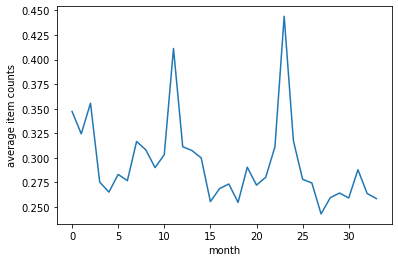

In [6]:
month_stats = month_sales.groupby("date_block_num")[["item_cnt_month", "item_price"]].mean()
fig = month_stats["item_cnt_month"].plot.line()
fig.set_xlabel("month")
fig.set_ylabel("average item counts")

## Decompose trends and seasonal pattern

Figure(432x288)


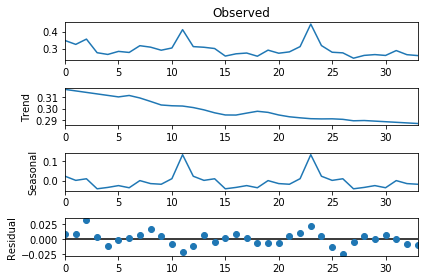

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
comp_sales = seasonal_decompose(month_stats["item_cnt_month"].values, 
                            model="additive", 
                            period=12,
                            extrapolate_trend=12)
print(comp_sales.plot())

> Down trend and seasonal pattern with period of one year are observed from monthly sales. We can decompose the data into three components.

# Feature Extraction

## Add month lag features

In [21]:
## Combine train and test for lag features
last_block = month_sales.date_block_num.max()
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
test["date_block_num"] = last_block + 1
month_sales["ID"] = -1
all_data = month_sales.append(test)
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,ID
139255,0,19,0,0.0,0.0,-1
141495,0,27,0,0.0,0.0,-1
144968,0,28,0,0.0,0.0,-1
142661,0,29,0,0.0,0.0,-1
138947,0,32,0,6.0,221.0,-1


In [22]:
## sales by shop
shop_sales = all_data.groupby(["shop_id", "date_block_num"])["item_cnt_month"].mean().reset_index()
shop_sales.rename(columns={"item_cnt_month": "sales_by_shop"}, inplace=True)

# sales by items
item_sales = all_data.groupby(["item_id", "date_block_num"])["item_cnt_month"].mean().reset_index()
item_sales.rename(columns={"item_cnt_month": "sales_by_item"}, inplace=True)

In [23]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
cols_to_rename = ["item_cnt_month"]

# shift_range = [i+1 for i in range(13)]
shift_range = [1,2,3,4,5,6,12]
min_date_block = 13

lag_features = []

for month_shift in shift_range:
    all_data_shift = all_data[index_cols + cols_to_rename].copy()
    all_data_shift['date_block_num'] = all_data_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    all_data_shift = all_data_shift.rename(columns=foo)

    lag_features += ['{}_lag_{}'.format(x, month_shift) for x in cols_to_rename]
    all_data = pd.merge(all_data, all_data_shift, on=index_cols, how='left')
    
    shop_sales_shift = shop_sales.copy()
    shop_sales_shift['date_block_num'] = shop_sales_shift['date_block_num'] + month_shift
    shop_sales_shift.rename(columns={'sales_by_shop': f'sales_by_shop_lag_{month_shift}'}, inplace=True)
    all_data = pd.merge(all_data, shop_sales_shift, on=['shop_id', 'date_block_num'], how='left')
    
    item_sales_shift = item_sales.copy()
    item_sales_shift['date_block_num'] = item_sales_shift['date_block_num'] + month_shift
    item_sales_shift.rename(columns={'sales_by_item': f'sales_by_item_lag_{month_shift}'}, inplace=True)
    all_data = pd.merge(all_data, item_sales_shift, on=['item_id', 'date_block_num'], how='left')
    
    lag_features += [f'sales_by_shop_lag_{month_shift}', f'sales_by_item_lag_{month_shift}']

del all_data_shift
del shop_sales_shift
del item_sales_shift

all_data

,shop_id,item_id,date_block_num,item_cnt_month,item_price,ID,item_cnt_month_lag_1,sales_by_shop_lag_1,sales_by_item_lag_1,item_cnt_month_lag_2,...,sales_by_item_lag_4,item_cnt_month_lag_5,sales_by_shop_lag_5,sales_by_item_lag_5,item_cnt_month_lag_6,sales_by_shop_lag_6,sales_by_item_lag_6,item_cnt_month_lag_12,sales_by_shop_lag_12,sales_by_item_lag_12
0,0,19,0,0.0,0.0,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,27,0,0.0,0.0,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,28,0,0.0,0.0,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,29,0,0.0,0.0,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,32,0,6.0,221.0,-1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11128045,45,18454,34,NaN,NaN,214195,1.0,0.126732,0.045455,0.0,...,0.279070,0.0,0.11944,0.441860,0.0,0.137611,0.590909,NaN,0.181272,NaN
11128046,45,16188,34,NaN,NaN,214196,0.0,0.126732,0.022727,0.0,...,NaN,NaN,0.11944,NaN,NaN,0.137611,NaN,NaN,0.181272,NaN
11128047,45,15757,34,NaN,NaN,214197,0.0,0.126732,0.113636,0.0,...,0.093023,0.0,0.11944,0.186047,0.0,0.137611,0.250000,0.0,0.181272,0.18
11128048,45,19648,34,NaN,NaN,214198,0.0,0.126732,0.045455,0.0,...,0.046512,0.0,0.11944,0.093023,0.0,0.137611,0.090909,NaN,0.181272,NaN


In [31]:
all_data["month"] = all_data["date_block_num"].map(lambda x: x%12)
month_features = ["month"]

In [29]:
## Split train and test data
train_data = all_data[all_data.date_block_num <= last_block].copy()
del train_data["ID"]
test_data = all_data[all_data.date_block_num == last_block + 1].copy()

## map item to category
item_category_map = dict(zip(items["item_id"], items["item_category_id"]))
train_data["category_id"] = train_data["item_id"].map(item_category_map)
test_data["category_id"]  = test_data["item_id"].map(item_category_map)

## generate shop item pairs
train_data["shop_item_id"] = train_data["shop_id"].astype(str) + "-" + train_data["item_id"].astype(str)
test_data["shop_item_id"] = test_data["shop_id"].astype(str) + "-" + test_data["item_id"].astype(str)

# Prepare training, validation and test data

##  Prepare data processing pipelines

In [33]:
features = lag_features + month_features
target = "item_cnt_month"

## Remove the first 12 months
train_data = train_data[train_data.date_block_num >= min_date_block]

dates_train = [d for d in range(27, last_block)]

## Test meta-features

In [34]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

## linear regression
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value=0)), 
                         ('std_scaler', StandardScaler())])



cat_pipeline = Pipeline([('one_hot_enc', OneHotEncoder())])
lr_pipeline = ColumnTransformer([
        ("num", num_pipeline, lag_features),
        ("cat", cat_pipeline, month_features),
    ])

lr_reg = LinearRegression()
X_train_block = train_data[train_data.date_block_num < last_block][features]
X_test_block = train_data[train_data.date_block_num == last_block][features]

Y_train_block = train_data[train_data.date_block_num < last_block][target]
Y_test_block = train_data[train_data.date_block_num == last_block][target]

X_train_prepared = lr_pipeline.fit_transform(X_train_block)
X_test_prepared = lr_pipeline.transform(X_test_block)

lr_reg.fit(X_train_prepared, Y_train_block.values)
pred_lr = lr_reg.predict(X_test_prepared)

rmse_lr = np.sqrt(mean_squared_error(Y_test_block.values, pred_lr))
print(f"RMSE for linear regression: {rmse_lr}")

RMSE for linear regression: 0.9690065651549296


In [35]:
## lightGBM
import lightgbm as lgb
lgb_pipeline = SimpleImputer(strategy='constant', fill_value=-999)

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':2, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 42, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

X_train_prepared = lgb_pipeline.fit_transform(X_train_block)
X_test_prepared = lgb_pipeline.transform(X_test_block)
    
train_ds= lgb.Dataset(X_train_prepared, label=Y_train_block)
lgb_reg = lgb.train(lgb_params, train_ds, 100)
pred_lgb = lgb_reg.predict(X_test_prepared)

rmse_lgb = np.sqrt(mean_squared_error(Y_test_block.values, pred_lgb))
print(f"RMSE for ligthGBM: {rmse_lgb}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.286818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
RMSE for ligthGBM: 0.9451291721320383


## Train meta-features

In [36]:
train_data_level2 = train_data[train_data.date_block_num.isin(dates_train)]
Y_train_level2 = train_data_level2[target]
X_train_level2 = np.zeros([Y_train_level2.shape[0], 2])

for cur_date in dates_train:
    print(cur_date)
    
    X_train_block = train_data[train_data.date_block_num < cur_date][features]
    X_test_block = train_data[train_data.date_block_num == cur_date][features]
    
    Y_train_block = train_data[train_data.date_block_num < cur_date][target]
    Y_test_block = train_data[train_data.date_block_num == cur_date][target]
    
    X_train_prepared = lr_pipeline.fit_transform(X_train_block)
    X_test_prepared = lr_pipeline.transform(X_test_block)
    
    lr_reg.fit(X_train_prepared, Y_train_block)
    Y_test_pred_lr = lr_reg.predict(X_test_prepared)
    X_train_level2[train_data_level2.date_block_num==cur_date, 0] = Y_test_pred_lr
    
    X_train_prepared = lgb_pipeline.fit_transform(X_train_block)
    X_test_prepared = lgb_pipeline.transform(X_test_block)
    
    train_ds= lgb.Dataset(X_train_prepared, label=Y_train_block)
    lgb_reg = lgb.train(lgb_params, train_ds, 100)
    Y_test_pred_lgb = lgb_reg.predict(X_test_prepared)
    X_train_level2[train_data_level2.date_block_num==cur_date, 1] = Y_test_pred_lgb
    

27
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
28
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.239163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
29
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.250884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
30
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.261694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
31
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the over

# Ensembling

In [37]:
stack_reg = LinearRegression()
stack_reg.fit(X_train_level2, Y_train_level2)

Y_test_meta = train_data[train_data.date_block_num == last_block][target]
Y_test_pred_meta = stack_reg.predict(np.c_[pred_lr, pred_lgb])
rmse_stack =  np.sqrt(mean_squared_error(Y_test_meta, Y_test_pred_meta))
print(f"RMSE for stacking: {rmse_stack}")

RMSE for stacking: 0.9432388675963299


## Retrain base linear regression model with all data

In [38]:
lr_reg = LinearRegression()
X_train_block = train_data[features]
X_test_block = test_data[features]

Y_train_block = train_data[target]
Y_test_block = test_data[target]

X_train_prepared = lr_pipeline.fit_transform(X_train_block)
X_test_prepared = lr_pipeline.transform(X_test_block)

lr_reg.fit(X_train_prepared, Y_train_block.values)
Y_test_pred_lr = lr_reg.predict(X_test_prepared)

## Retrain base lightGBM model with all data

In [39]:
X_train_prepared = lgb_pipeline.fit_transform(X_train_block)
X_test_prepared = lgb_pipeline.transform(X_test_block)
    
train_ds= lgb.Dataset(X_train_prepared, label=Y_train_block)
lgb_reg = lgb.train(lgb_params, train_ds, 100)
Y_test_pred_lgb = lgb_reg.predict(X_test_prepared)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.325224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


## Retrain meta model with all data

In [40]:
X_train_level2_all = np.concatenate([X_train_level2, np.c_[pred_lr, pred_lgb]])
Y_train_level2_all = np.concatenate([Y_train_level2, Y_test_meta])
stack_reg.fit(X_train_level2_all, Y_train_level2_all)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
test_data["item_cnt_month"] = stack_reg.predict(np.c_[Y_test_pred_lr, Y_test_pred_lgb])
test_data["item_cnt_month"] = test_data["item_cnt_month"].map(clip_values)
test_data[["ID", "item_cnt_month"]].to_csv("submission3_stack.csv", index=False)